## Distributed Acoustic Sensing (DAS) at the Ocean Observatory Initiative (OOI) Regional Cabled Array (RCA)

#### Ethan F. Williams (<efwillia@uw.edu>), Qibin Shi (<qibins@uw.edu>)

This notebook provides a basic tutorial to read and visualize 2024 DAS data offshore Central Oregon

In [1]:
import os
import h5py
import numpy as np
import scipy.signal as sgn
from scipy.signal import butter, filtfilt, detrend, hilbert, decimate
from scipy.signal.windows import tukey

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from pyproj import Proj

### 1. Download and read .h5 files

This experiment utilized an Alcatel Submarine Networks (ASN) OptoDAS interrogator unit, which wrote ```.h5``` format files at 10-second interval. Data are archived through OOI and may be accessed at <http://piweb.ooirsn.uw.edu/das24/>. Interested individuals may also contact Mitch Elend (<melend@uw.edu>) to arrange to send hard disk drives which will be returned with the requested data.

In [ ]:
## Obtain files from OOI web server

fdir = '/data/fast0/ethan-scratch/notebook/data' # local destination for files
waddr = 'http://piweb.ooirsn.uw.edu/das24/data/20240508/dphi/'
f0 = 5  # trailing seconds in first file
df = 10 # interval between file time stamps
nf = 12 # number of files to get
flist = []
for i, f in enumerate(range(f0,nf*df+f0,df)):
    h = f//(60*60)
    m = (f-h*60*60)//60
    s = f-h*60*60-m*60
    fname = '%02d%02d%02d.hdf5' % (h,m,s)
    flist.append(fname)
    print('(%d/%d) Fetching %s' % (i+1,nf,fname))
    os.system('wget -q -P %s %s' % (fdir, waddr + fname))

(1/12) Fetching 000005.hdf5
(2/12) Fetching 000015.hdf5
(3/12) Fetching 000025.hdf5
(4/12) Fetching 000035.hdf5
(5/12) Fetching 000045.hdf5
(6/12) Fetching 000055.hdf5
(7/12) Fetching 000105.hdf5
(8/12) Fetching 000115.hdf5
(9/12) Fetching 000125.hdf5
(10/12) Fetching 000135.hdf5
(11/12) Fetching 000145.hdf5
(12/12) Fetching 000155.hdf5


In [5]:
## Extract basic metadata

with h5py.File(os.path.join(fdir,flist[0]),'r') as fp:
    
    gl = fp['header/gaugeLength'][()]
    t0 = fp['header/time'][()]
    dt = fp['header/dt'][()]
    fs = 1./dt
    dx = fp['header/dx'][()]*10 # not sure why this is incorrect
    un = fp['header/unit'][()]
    ns = fp['/header/dimensionRanges/dimension0/size'][()]
    nx = fp['/header/dimensionRanges/dimension1/size'][()][0]
    rf = fp['/cableSpec/refractiveIndex'][()]
print('Gauge length (m):\t\t', gl)
print('Start time (s since 1 Jan 1970):', t0)
print('Sample interval (s):\t\t',dt)
print('Sampling rate (Hz):\t\t',fs)
print('Channel interval (m):\t\t',dx)
print('Unit:\t\t\t\t',un.decode('UTF-8'))
print('fiber refractive index:\t\t',rf)

Gauge length (m):		 40.85200763098726
Start time (s since 1 Jan 1970): 1715126405.302
Sample interval (s):		 0.005
Sampling rate (Hz):		 200.0
Channel interval (m):		 10.213001907746815
Unit:				 rad/(s*m)
fiber refractive index:		 1.4677


In [3]:
## You can see the complete file structure with normal HDF5 utilities

!h5dump -n {os.path.join(fdir,flist[0])} | grep fract

 dataset    /cableSpec/refractiveIndex
 dataset    /processingChain/step-0/cols/roiRefractiveIndex
 dataset    /processingChain/step-1/cols/roiRefractiveIndex


### 2. Plot data in time and frequency domains

Microseism (Rayleigh/Scholte waves) traverses the array quickly and is local amplified by small-scale basin structures across the shelf.

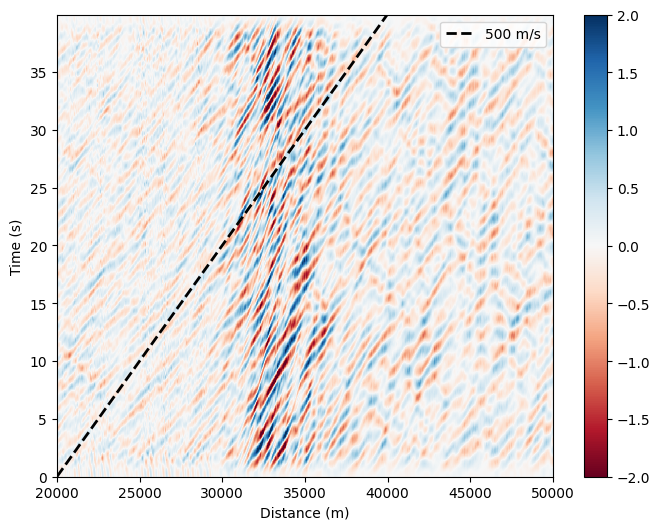

In [6]:
N = 4
data = np.zeros((ns*N,nx))
for i in range(N):
    with h5py.File(os.path.join(fdir,flist[i]),'r') as fp:
        data[i*ns:(i+1)*ns,:] = fp['data'][:]

t = np.arange(ns*N)/fs        
x = np.arange(nx)*dx

fmin = 0.2
fmax = 2
b,a = butter(4,[fmin,fmax],fs=fs,btype='bandpass')
data = detrend(data,axis=0)
data *= np.tile(tukey(ns*N,alpha=0.1),(nx,1)).T
data = filtfilt(b,a,data,axis=0)

# cut down for plotting 
data = data[::10,:]
t = t[::10]
xmin = 2e4
xmax = 5e4
idx = np.logical_and(x>=xmin,x<=xmax)

fig,ax = plt.subplots(1,1,figsize=(8,6))
im = ax.pcolormesh(x[idx],t,data[:,idx],cmap='RdBu',vmin=-2,vmax=2)
ax.plot(x[idx],(x[idx]-xmin)/500,'k--',linewidth=2,label='500 m/s')
ax.legend(loc='upper right')
ax.set_xlim([xmin,xmax])
ax.set_ylim([min(t),max(t)])
ax.set_ylabel('Time (s)')
ax.set_xlabel('Distance (m)')
fig.colorbar(im,ax=ax)

Ocean surface gravity waves traverse the array slowly, and their amplitude increases with decreasing water depth approaching the beach.

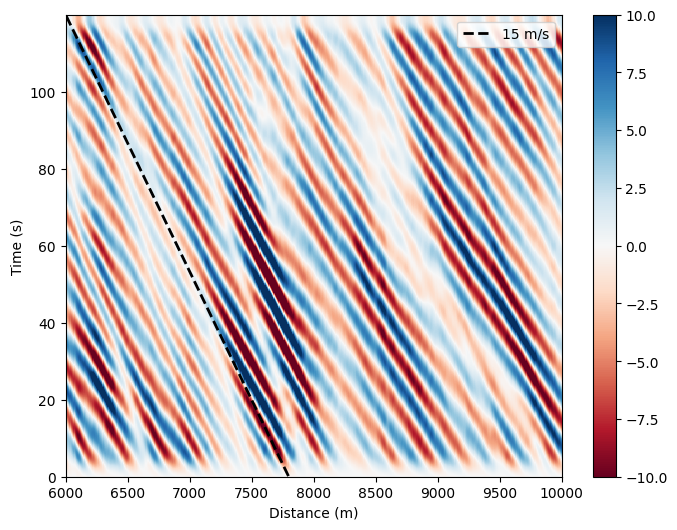

In [7]:
N = 12
data = np.zeros((ns*N,nx))
for i in range(N):
    with h5py.File(os.path.join(fdir,flist[i]),'r') as fp:
        data[i*ns:(i+1)*ns,:] = fp['data'][:]

t = np.arange(ns*N)/fs        
x = np.arange(nx)*dx

fmax = 0.2
b,a = butter(4,fmax,fs=fs,btype='lowpass')
data = detrend(data,axis=0)
data *= np.tile(tukey(ns*N,alpha=0.1),(nx,1)).T
data = filtfilt(b,a,data,axis=0)

# cut down for plotting 
data = data[::10,:]
t = t[::10]
xmin = 6e3
xmax = 10e3
idx = np.logical_and(x>=xmin,x<=xmax)

fig,ax = plt.subplots(1,1,figsize=(8,6))
im = ax.pcolormesh(x[idx],t,data[:,idx],cmap='RdBu',vmin=-10,vmax=10)
ax.plot(x[idx],max(t)-(x[idx]-xmin)/15,'k--',linewidth=2,label='15 m/s')
ax.legend(loc='upper right')
ax.set_xlim([xmin,xmax])
ax.set_ylim([min(t),max(t)])
ax.set_ylabel('Time (s)')
ax.set_xlabel('Distance (m)')
fig.colorbar(im,ax=ax)

Power spectral density at different locations

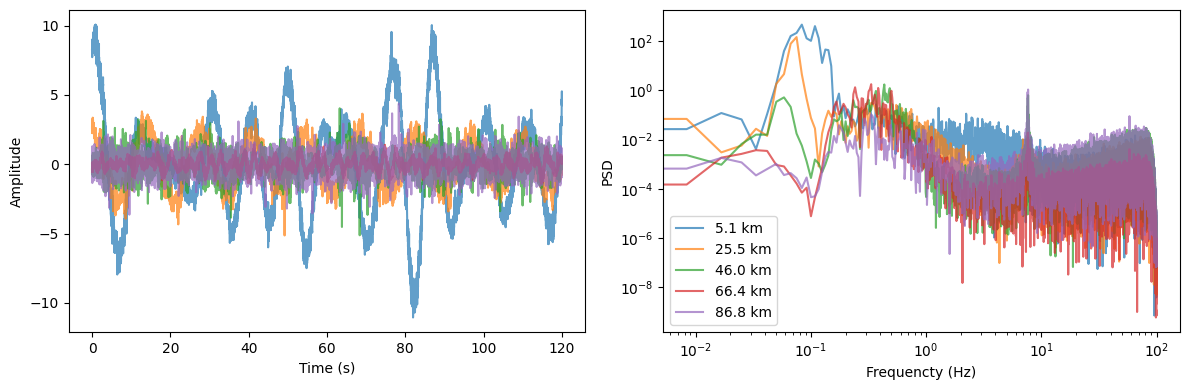

In [28]:
N = 12
data = np.zeros((ns*N,nx))
for i in range(N):
    with h5py.File(os.path.join(fdir,flist[i]),'r') as fp:
        data[i*ns:(i+1)*ns,:] = fp['data'][:]


t = np.arange(ns*N)/fs        
x = np.arange(nx)*dx

nt, nx = data.shape

fig,ax = plt.subplots(1,2,figsize=(12,4))

for chan in np.arange(500,nx,2000):
    tr = data[:,chan]
    tr -= np.mean(tr) # remove the mean
    freq, psd = sgn.periodogram(tr, fs, window='hamming')
    ax[0].plot(np.arange(nt) / fs, tr, alpha=0.7, label='%.1f km' % (chan*dx*1e-3))
    ax[1].loglog(freq,psd,label='%.1f km' % (chan*dx*1e-3), alpha=0.7)
    
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequencty (Hz)')
ax[1].set_ylabel('PSD')
plt.legend()
plt.tight_layout()

For more examples of data visualization, see the tutorial notebook from the 2021 OOI DAS pilot experiment: <https://github.com/ethanfwilliams/OOI_RCA_DAS_notebook>.

### 3. Cable geometry

Visualize a 10-second data with 9500 channels

Number of channels: 9500
Number of time samples: 2000
Channel spacing (m): 10.213001907746815
sample interval (s): 0.005


Text(0, 0.5, 'Time sample')

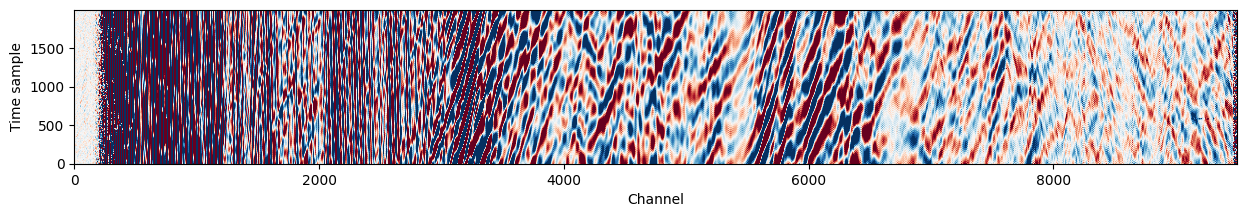

In [5]:
with h5py.File('/1-fnp/petasaur/p-wd02/muxDAS/20240507/dphi/131805.hdf5', 'r') as f:
    time_data =f['data'][:, :].T
    dx = f['header/dx'][()] * 10  ## channel spacing in meters
    dt = f['header/dt'][()]  ## time spacing in seconds
nx = time_data.shape[0]
nt = time_data.shape[1]
print('Number of channels:', nx)
print('Number of time samples:', nt)
print('Channel spacing (m):', dx)
print('sample interval (s):', dt)

### see what the data looks like
plt.figure(figsize=(15, 2))
plt.imshow(time_data.T, aspect='auto', cmap='RdBu', vmin=-0.5, vmax=0.5, origin='lower')
plt.xlabel('Channel')
plt.ylabel('Time sample')

We use two well-localized points on the cable and interpolate the channels with the nominal channels spacing.

1. The first point is the beach location where the tidal energy dies off suddenly.
2. The second point is the repeater at the end of the sensing range where all signals disappear.

We will find the two points by calculating the median energy for each channel.

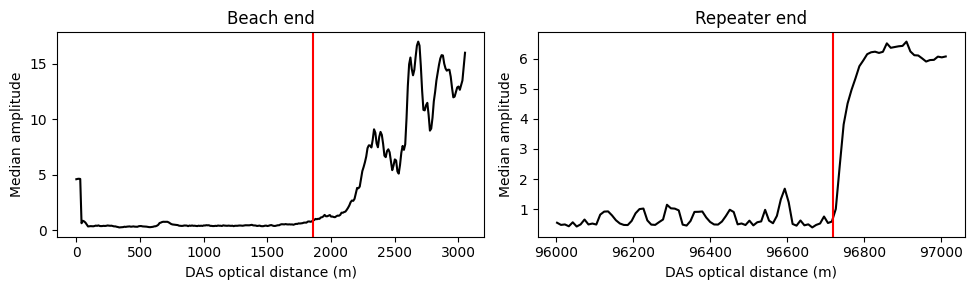

In [4]:
# Load beginning and end of dataset
i1 = 300
i2 = 100

data1 = time_data[:i1,:]
data2 = time_data[-i2:,:]

x1 = np.arange(i1) * dx
x2 = (np.arange(i2) + (nx-i2)) * dx

# Get median amplitude for each channel at the beach
data1 = data1.astype(float)
data1 -= np.mean(data1, axis=1, keepdims=True)
data1 = abs(hilbert(data1, axis=1))
amp1 = np.median(data1,axis=1)

# Get median amplitude for each channel at the repeater
data2 = data2.astype(float)
data2 -= np.mean(data2, axis=1, keepdims=True)
data2 = abs(hilbert(data2, axis=1))
amp2 = np.median(data2,axis=1)

# Plot the amplitude profile and pick the beach and repeater locations
x1_pick = 1860
x2_pick = 96720

fig,ax = plt.subplots(1,2,figsize=(10,3))
ax[0].plot(x1,amp1,'k')
ax[0].axvline(x1_pick,c='r')
ax[0].set_xlabel('DAS optical distance (m)')
ax[0].set_ylabel('Median amplitude')
ax[0].set_title('Beach end')
ax[1].plot(x2,amp2,'k')
ax[1].axvline(x2_pick,c='r')
ax[1].set_xlabel('DAS optical distance (m)')
ax[1].set_ylabel('Median amplitude')
ax[1].set_title('Repeater end')
plt.tight_layout()

Use the two points to interpolate the cable locations

In [6]:
# For clarity, c now refers to channels and x refers to longitude
nc = nx                      # number of channels
dc = dx                      # channel spacing
c = np.arange(nc,dtype=int)
c0 = int(x1_pick//dc)
c1 = int(x2_pick//dc)        # channel numbers of beginning and end
c = c[c0:c1+1]               # cut off beginning and ending channels
nc = len(c)                  # new number of channels
d = np.arange(nc)*dc         # optical distance from first good channel

### Get the coordinates of the OOI south cable
web_file='http://piweb.ooirsn.uw.edu/das/processed/metadata/Geometry/OOI_RCA_DAS_channel_location_with_depth/south_DAS_latlondepth.txt'
os.system('wget -q -P %s %s' % (fdir, web_file))
tmp = np.genfromtxt(fdir+'/south_DAS_latlondepth.txt')

# Load cable coordinates and convert to northing/easting
lat = tmp[:,1]
lon = tmp[:,2]
dep = tmp[:,3]

myProj = Proj("+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
x,y = myProj(lon,lat)

# Calculate geographic distance along cable track 
xd = np.diff(x)
yd = np.diff(y)
dd = np.sqrt(xd**2 + yd**2)
u = np.cumsum(dd)
u = np.hstack(([0],u))

# Interpolate channel locations in x,y
du = np.linspace(0,u.max(),nc)
xc = np.interp(du,u,x)
yc = np.interp(du,u,y)
zc = np.interp(du,u,dep)

# Convert channel locations back to lat,lon
lonc,latc = myProj(xc,yc,inverse=True)

print('Optical channel spacing, ',dc)
print('Geographic channel spacing, ',du[1]-du[0])
print('Difference, ', (du[1]-du[0])/dc)

Optical channel spacing,  10.213001907746815
Geographic channel spacing,  10.205246353661382
Difference,  0.9992406195401227


Text(0, 0.5, 'Latitude')

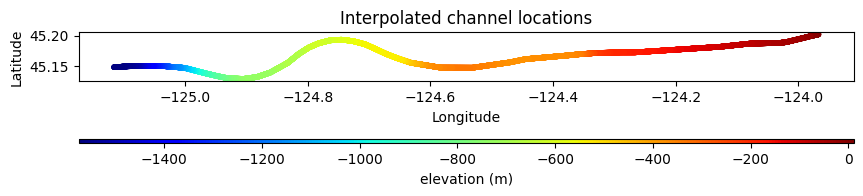

In [13]:
## Plot
plt.figure(figsize=(10,5))
cb = plt.scatter(lonc,latc,c=zc,marker='.',cmap='jet')
plt.colorbar(cb, label='elevation (m)', orientation='horizontal', aspect=200)
plt.gca().set_aspect('equal')
plt.title('Interpolated channel locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')